In [1]:
import gym
import torch.nn as nn
from seagul.rl.algos.sac import sac
from seagul.nn import MLP, CategoricalMLP
import torch
import matplotlib.pyplot as plt
from seagul.rl.models import SACModel
from multiprocessing import Process


# TODO for this to work need to convert from numpy dtype to torch
env_name = "Pendulum-v0"
# env = gym.make(env_name)
# dtype = env.action_space.sample().dtype

torch.set_default_dtype(torch.float32)

input_size = 3
output_size = 1
layer_size = 64
num_layers = 2
activation = nn.ReLU

policy = MLP(input_size, output_size*2, num_layers, layer_size, activation)

# Do I need to do weight sharing here?
value_fn = MLP(input_size, 1, num_layers, layer_size, activation)
q1_fn = MLP(input_size + output_size, 1, num_layers, layer_size, activation)
q2_fn = MLP(input_size + output_size, 1, num_layers, layer_size, activation)

model = SACModel(policy, value_fn, q1_fn, q2_fn, 1)

def run_and_test(arg_dict,seed):
    t_model, rewards, var_dict = ppo("Pendulum-v0", 200*2048, model, seed=seed, **arg_dict)

    if (var_dict['early_stop']):
        print("seed", seed, "achieved 200 reward in ", len(rewards), "steps")
    #        print("Rewards were", rewards)

    else:
        print("Error: seed:" , seed, "failed")
        print("Rewards were", rewards)

    return
    

# Define our hyper parameters
arg_dict = {
    'reward_stop' : -200,
    'pol_lr' : 1e-3,
    'val_lr' : 1e-3,
    'q_lr' : 1e-3,
    'seed' : 2,
}

model, rews, var_dict = sac(env_name, 10000, model,**arg_dict)
print(rews)

# proc_list = []
# for seed in [0,1,2,3]:
#     p = Process(target=run_and_test, args=(arg_dict, seed))
#     p.start()
#     proc_list.append(p)


# for p in proc_list:
#     print("joining")
#     p.join()

globals().update(var_dict)

/Users/sgillen/work/seagul/seagul/envs/__init__.py:76: UserWarning: Warning, registering environments for rllib failed!
  warnings.warn("Warning, registering environments for rllib failed!")
/Users/sgillen/work/seagul/seagul/rl/algos/__init__.py:8: UserWarning: tensorflow not installed, skipping symmetric ppo
  warnings.warn("tensorflow not installed, skipping symmetric ppo")
/Users/sgillen/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
 78%|███████▊  | 7800/10000 [01:43<00:30, 71.94it/s]

[tensor(-842.9138), tensor(-1786.2522), tensor(-1368.0969), tensor(-1088.5397), tensor(-1765.9912), tensor(-1460.9462), tensor(-1230.6567), tensor(-1282.8071), tensor(-1101.8510), tensor(-1212.3923), tensor(-1371.1476), tensor(-1073.9126), tensor(-1275.0244), tensor(-1177.0383), tensor(-1103.4336), tensor(-1011.1912), tensor(-506.6921), tensor(-981.6783), tensor(-504.1094), tensor(-1024.2181), tensor(-1006.5134), tensor(-745.0872), tensor(-866.1473), tensor(-503.1446), tensor(-245.6592), tensor(-916.8923), tensor(-371.7769), tensor(-856.0344), tensor(-371.7852), tensor(-247.1811), tensor(-126.9368), tensor(-737.2263), tensor(-124.1527), tensor(-248.1407), tensor(-122.9467), tensor(-491.3046), tensor(-125.2831), tensor(-122.5894)]


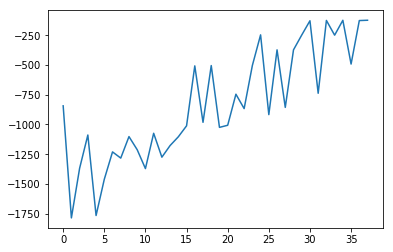

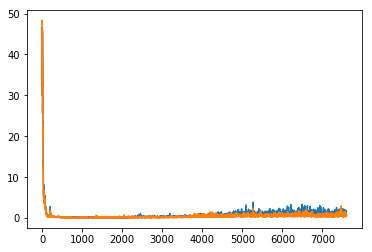

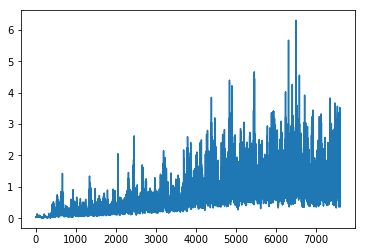

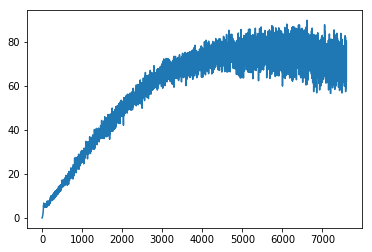

In [2]:
plt.plot(raw_rew_hist)
plt.figure()
plt.plot(q1_loss_hist)
plt.plot(q2_loss_hist)
plt.figure()
plt.plot(val_loss_hist)
plt.figure()
plt.plot(pol_loss_hist)

In [4]:
replay_obs1, replay_obs2, replay_acts, replay_rews, replay_done = replay_buf.sample_batch(replay_batch_size)


In [6]:
replay_buf.sample_batch()

(tensor([[-4.3716e-01, -8.9938e-01,  7.5614e+00],
         [ 2.7981e-01, -9.6005e-01,  6.0122e+00],
         [-6.6774e-01, -7.4439e-01,  1.9993e+00],
         [-6.2529e-01, -7.8039e-01,  1.9571e+00],
         [-8.6751e-01,  4.9742e-01, -9.0973e-02],
         [-8.0000e-01,  6.0000e-01, -1.1238e+00],
         [-9.9995e-01,  1.0270e-02,  1.5052e+00],
         [-9.8631e-01,  1.6490e-01, -6.0215e-01],
         [-9.8900e-01,  1.4789e-01, -1.6301e+00],
         [-9.6875e-01,  2.4805e-01,  2.5050e+00],
         [-4.5598e-01, -8.8999e-01,  1.1645e+00],
         [-4.5555e-01, -8.9021e-01,  3.4157e+00],
         [ 1.9587e-02, -9.9981e-01, -3.7314e-01],
         [-8.8173e-01,  4.7176e-01,  8.0000e+00],
         [-9.9758e-01, -6.9506e-02, -3.5774e+00],
         [-8.1126e-01,  5.8469e-01,  8.0000e+00],
         [-9.9996e-01, -9.4351e-03, -4.3561e+00],
         [-9.9295e-01, -1.1852e-01,  4.8240e+00],
         [-4.8092e-02, -9.9884e-01,  6.7154e+00],
         [-3.1406e-01, -9.4940e-01,  6.5436e+00],


In [69]:
import math
import numpy as np
means = torch.zeros(3)
std = torch.ones(1)
log_std = torch.log(std)


In [18]:
%%timeit
logp = torch.log(1/(std*math.sqrt(2*np.pi))*torch.exp(-.5*torch.pow((acts-means)/std,2)))

67.7 µs ± 879 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [41]:
%%timeit
logp = torch.log(1/(std*math.sqrt(2*np.pi))) - .5*torch.pow((acts-means),2)

67.1 µs ± 2.79 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [22]:
%%timeit
m = torch.distributions.normal.Normal(means, std)
logp = m.log_prob(acts)

105 µs ± 4.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [70]:
%%timeit
logp = -((acts - means) ** 2) / (2 * torch.pow(std,2)) - log_std - math.log(math.sqrt(2 * math.pi))



48.6 µs ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [65]:
%%timeit
model.select_action(replay_obs1[0].reshape(1,-1), noise[0].reshape(1,-1))

529 µs ± 38.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
